07:24:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:24:04 - cmdstanpy - INFO - CmdStan done processing.


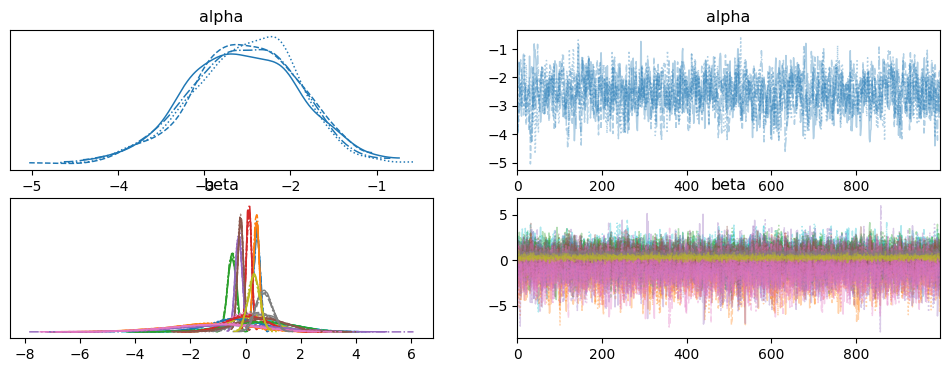

<xarray.Dataset> Size: 648kB
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 19)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 152B 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18
Data variables:
    beta        (chain, draw, beta_dim_0) float64 608kB 0.3886 0.2805 ... 0.2317
    alpha       (chain, draw) float64 32kB -1.888 -2.219 ... -2.661 -2.788
Attributes:
    created_at:                 2025-06-16T07:24:04.608845+00:00
    arviz_version:              0.21.0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.5


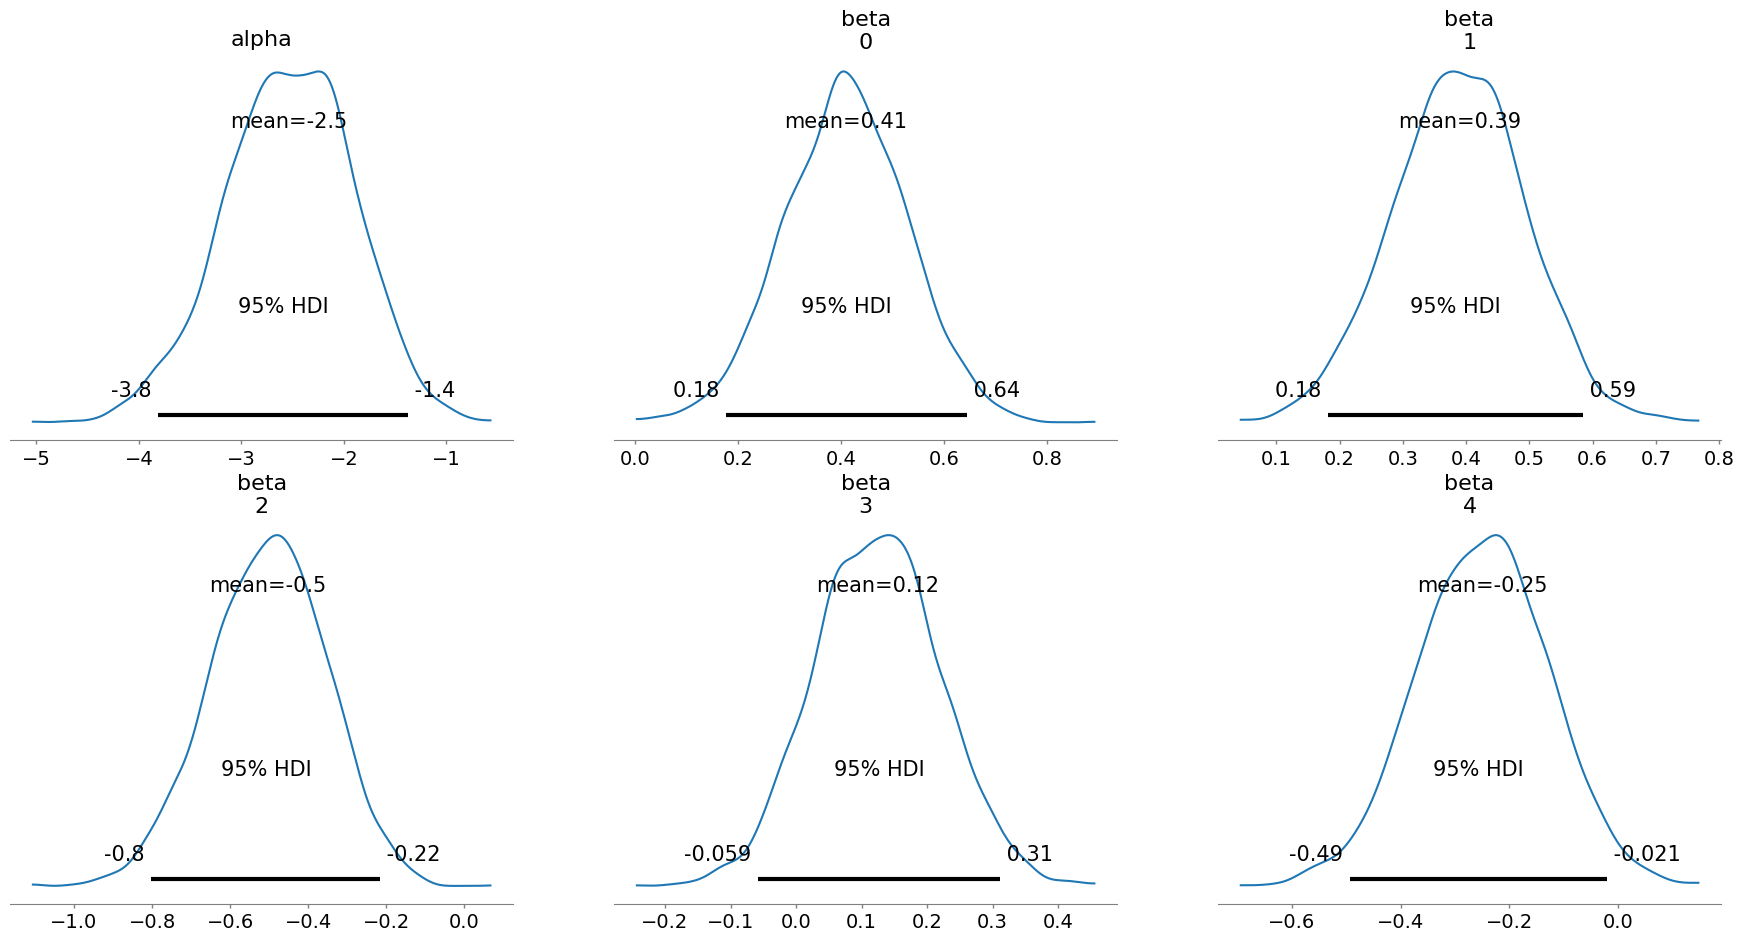

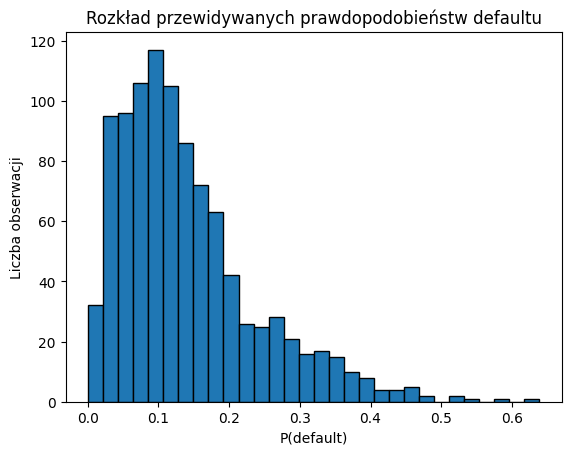

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as az

# Wczytaj dane
X, y, purpose = joblib.load("processed_data.pkl")

# Konwersja na odpowiedni typ i format
if hasattr(X, 'toarray'):
    X = X.toarray()

X = X.astype(np.float32)
y = y.astype(np.int32)

N, K = X.shape

# Zapisz dane do Stan (w formacie JSON)
stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# Wczytaj i uruchom model Stan
model = CmdStanModel(stan_file="model1.stan")
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)

# Konwersja wyników do formatu ArviZ
idata = az.from_cmdstanpy(posterior=fit)

# TRACEPLOT - ślady łańcuchów MCMC
az.plot_trace(idata, var_names=["alpha", "beta"])
plt.show()

# Podejrzyj strukturę posteriora, żeby wiedzieć jak się odwoływać do beta
print(idata.posterior)

# POSTERIOR PLOT – tylko dla alpha i pierwszych 5 beta
az.plot_posterior(idata, var_names=["alpha", "beta"], coords={"beta_dim_0": list(range(5))}, hdi_prob=0.95)
plt.show()

# Średnie wartości posteriora (do predykcji)
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
alpha_mean = posterior_means["alpha"].values.item()
beta_mean = posterior_means["beta"].values

# Predykcja prawdopodobieństw (logit -> sigmoid)
logits = alpha_mean + X @ beta_mean
probs = 1 / (1 + np.exp(-logits))

# Histogram prawdopodobieństw defaultu
plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych prawdopodobieństw defaultu")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()


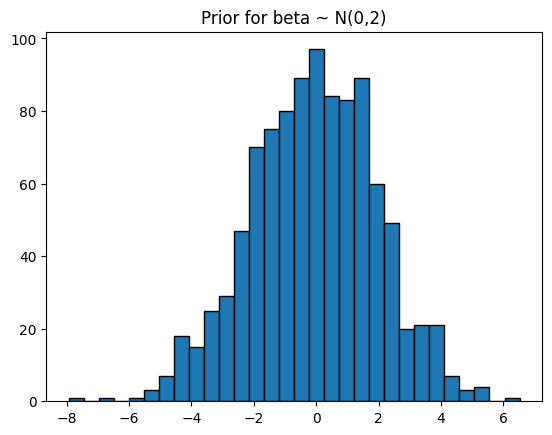

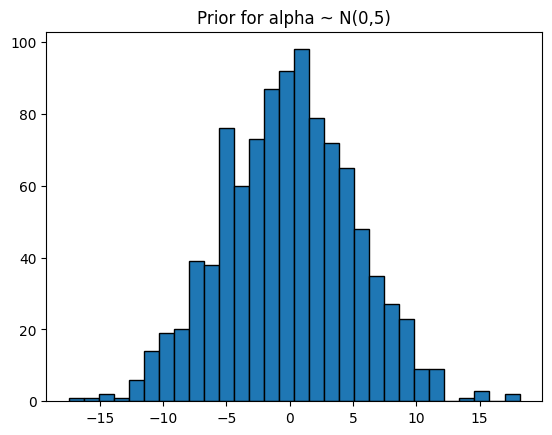

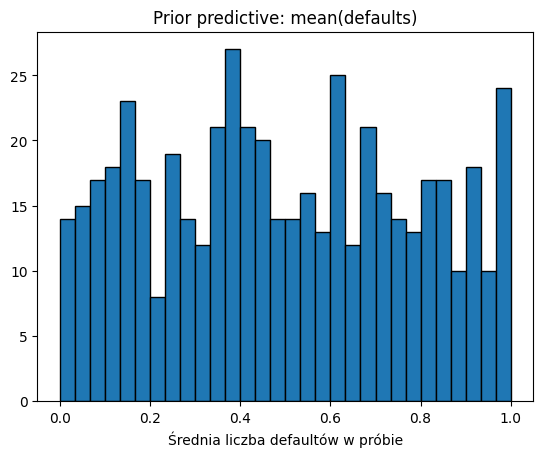

07:36:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:36:05 - cmdstanpy - INFO - CmdStan done processing.



          r_hat  ess_bulk  ess_tail
alpha      1.01     947.0    1608.0
beta[0]    1.00    3585.0    3309.0
beta[1]    1.00    4581.0    3082.0
beta[2]    1.00    3683.0    3441.0
beta[3]    1.00    7139.0    3247.0
beta[4]    1.00    4751.0    2986.0
beta[5]    1.00    4842.0    3016.0
beta[6]    1.01     996.0    1772.0
beta[7]    1.01     934.0    1653.0
beta[8]    1.00    1210.0    1913.0
beta[9]    1.00    3915.0    3253.0
beta[10]   1.00    1750.0    2427.0
beta[11]   1.00    4841.0    2776.0
beta[12]   1.00    3394.0    2655.0
beta[13]   1.00    1044.0    1904.0
beta[14]   1.00    6061.0    2681.0
beta[15]   1.00    1791.0    2385.0
beta[16]   1.00    5655.0    2510.0
beta[17]   1.00    4540.0    2986.0
beta[18]   1.00    4750.0    3192.0
Divergences: 0


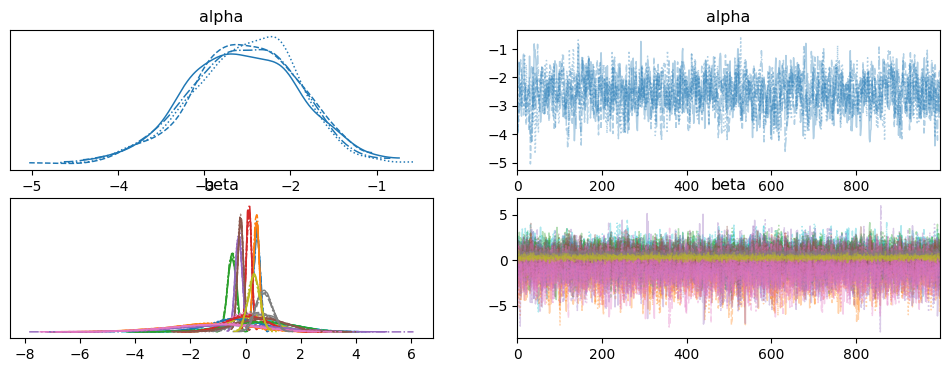

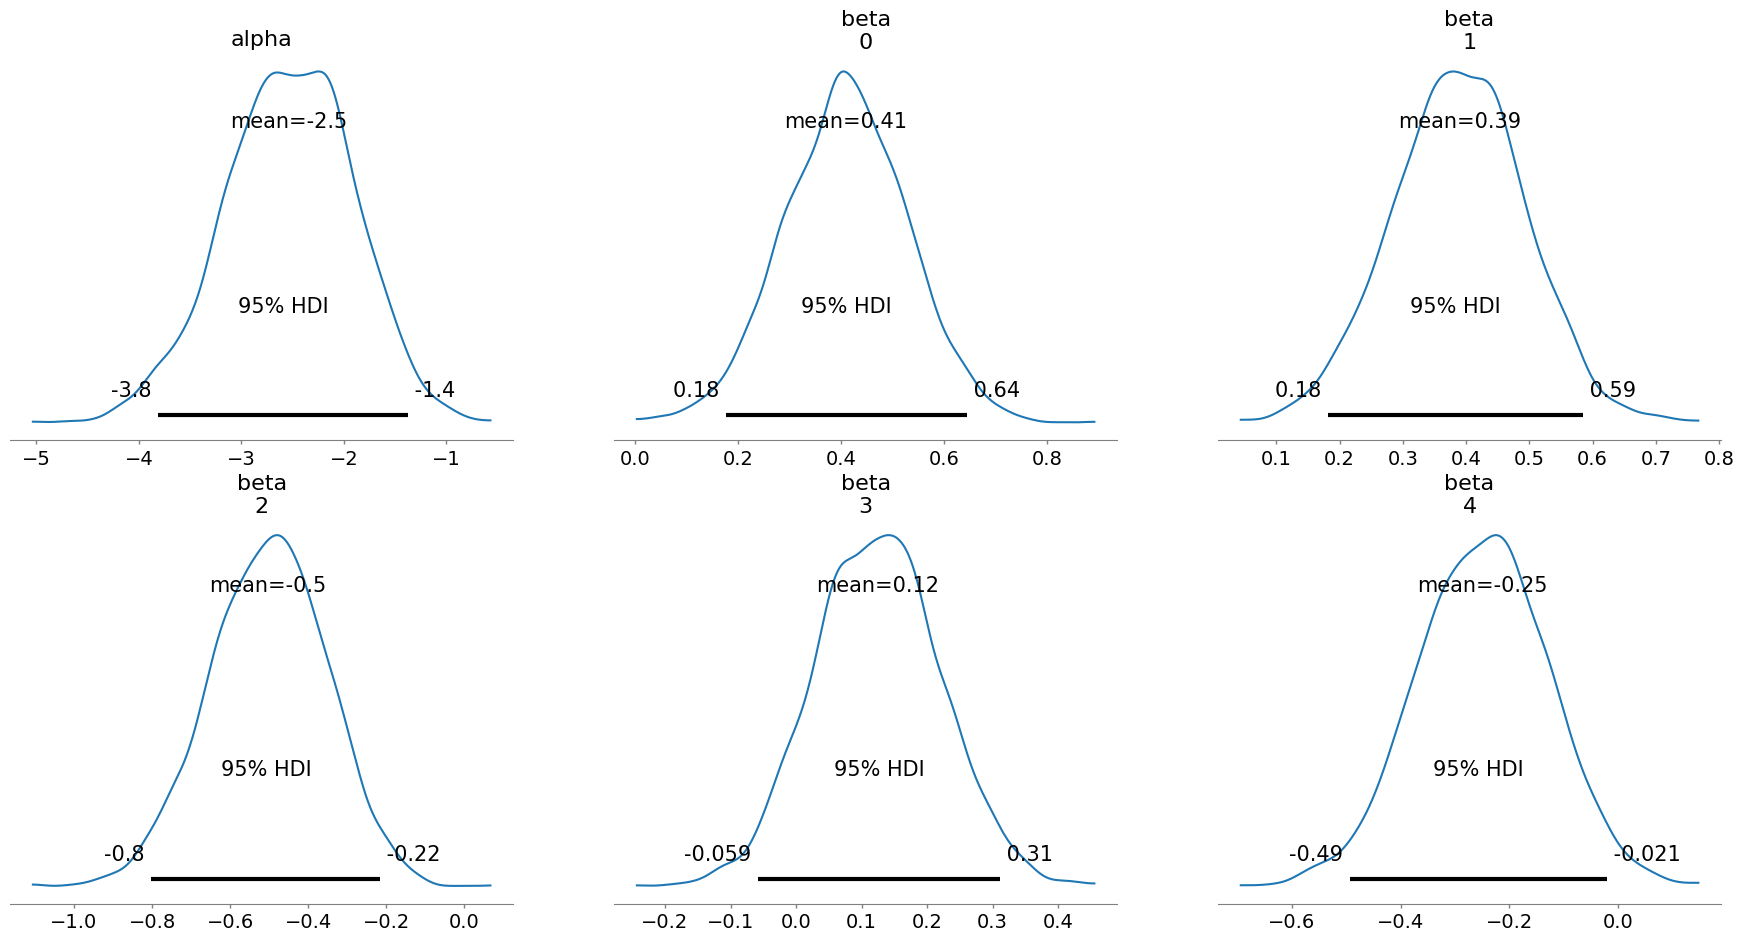

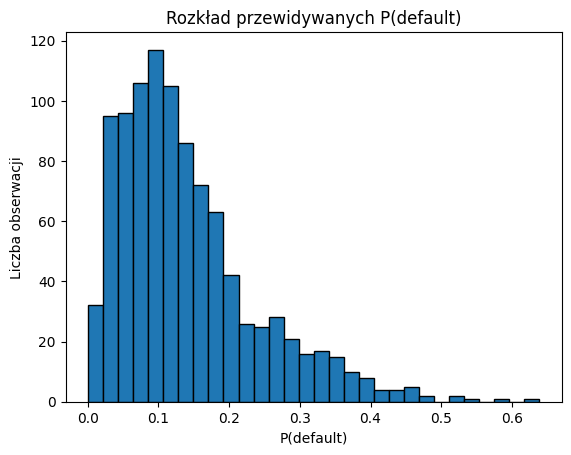

Dokładność klasyfikacji: 0.86


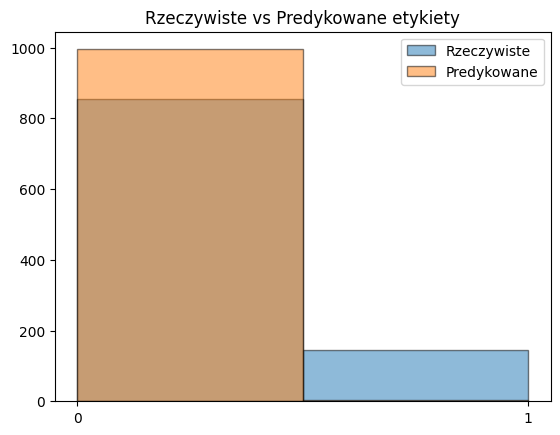

In [4]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel

# === Wczytanie danych ===
X, y, purpose = joblib.load("processed_data.pkl")
if hasattr(X, 'toarray'):
    X = X.toarray()

X = X.astype(np.float32)
y = y.astype(np.int32)
N, K = X.shape

stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist()
}

# === PRIOR PREDICTIVE CHECK – PARAMETRY ===
alpha_prior = np.random.normal(0, 5, 1000)
beta_prior = np.random.normal(0, 2, 1000)

plt.hist(beta_prior, bins=30, edgecolor='k')
plt.title("Prior for beta ~ N(0,2)")
plt.show()

plt.hist(alpha_prior, bins=30, edgecolor='k')
plt.title("Prior for alpha ~ N(0,5)")
plt.show()

# === PRIOR PREDICTIVE CHECK – DANE ===
n_samples = 500
beta_samples = np.random.normal(0, 2, (n_samples, K))
alpha_samples = np.random.normal(0, 5, n_samples)

logits = alpha_samples[:, None] + beta_samples @ X.T
probs_prior = 1 / (1 + np.exp(-logits))
y_sim = np.random.binomial(1, probs_prior)
mean_defaults = y_sim.mean(axis=1)

plt.hist(mean_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive: mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.show()

# === KOMPILOWANIE I URUCHOMIENIE MODELU ===
model = CmdStanModel(stan_file="model1.stan")
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    seed=42
)

idata = az.from_cmdstanpy(posterior=fit)

# === SPRAWDZENIE JAKOŚCI PRÓBKOWANIA ===
summary = az.summary(idata, var_names=["alpha", "beta"])
print(summary[["r_hat", "ess_bulk", "ess_tail"]])
print("Divergences:", int(idata.sample_stats["diverging"].sum()))

# === ŚLADY I ROZKŁADY POSTERIORA ===
az.plot_trace(idata, var_names=["alpha", "beta"], compact=True)
plt.show()

az.plot_posterior(
    idata,
    var_names=["alpha", "beta"],
    coords={"beta_dim_0": list(range(5))},
    hdi_prob=0.95
)
plt.show()

# === ŚREDNIE PARAMETRY POSTERIORA DO PREDYKCJI ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
alpha_mean = posterior_means["alpha"].values.item()
beta_mean = posterior_means["beta"].values

logits = alpha_mean + X @ beta_mean
probs = 1 / (1 + np.exp(-logits))

# === HISTOGRAM PREDYKCJI P(default) ===
plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych P(default)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()

# === PORÓWNANIE Y vs Y_PRED ===
y_pred = (probs > 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Dokładność klasyfikacji: {acc:.2f}")

plt.hist(y, bins=2, alpha=0.5, label="Rzeczywiste", edgecolor='k')
plt.hist(y_pred, bins=2, alpha=0.5, label="Predykowane", edgecolor='k')
plt.xticks([0, 1])
plt.legend()
plt.title("Rzeczywiste vs Predykowane etykiety")
plt.show()

